# Get your dependencies and file name

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import lsdtopytools as lsd
import lsdttparamselector as ps
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
import lsdviztools.lsdmapwrappers as lsdmw
import lsdttparamselector as ps

import fiona
import rasterio
from rasterio.mask import mask
from osgeo import gdal

from scipy.stats import binned_statistic

%matplotlib inline

In [2]:
#Get file into LSDTT format
DataDirectory = "./"
RasterFile = "tile_20.tif"

#These next two lines are just to get the file name
position=RasterFile.index('.')
filename=RasterFile[0:position]


# Run LSDTT command line tool 

In [ ]:
#This step doesn't show up in every LSDTT notebook/example but I found that it's the only way to guarantee
#you're projected properly. Otherwise the script will run but all your rasters will be null
gio.convert4lsdtt(DataDirectory, RasterFile,minimum_elevation=0.01,resolution=3)

In [3]:
#This is where you tell the lsdtt tool what parameters you want so that it makes a driver file, just like the command-line tool 
lsdtt_parameters = {"surface_fitting_radius" : "3",
                    "print_slope" : "true",
                    "print_curvature" : "true",
                    "print_dinf_drainage_area_raster": "true"}

#As you can see, the output then becomes 'filename + _UTM' so I had to do a small amount of sorcery to get the script
#to run on the slightly differently named file
lsdtt_drive = lsdmw.lsdtt_driver(read_prefix = filename + "_UTM",
                                 write_prefix= filename + "_UTM",
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)

#And this ives you a double-check that the driver file is what you expect it to be. 
lsdtt_drive.print_parameters()


The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: tile_20_UTM
The write prefix is: tile_20_UTM
The parameter dictionary is:
{'surface_fitting_radius': '3', 'print_slope': 'true', 'print_curvature': 'true', 'print_dinf_drainage_area_raster': 'true'}


In [4]:
#And this runs it!
lsdtt_drive.run_lsdtt_command_line_tool()

Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


In [6]:
#This cell is a little annoying step that takes the output .bil files and turns them into .tifs that ratserio and fiona can read
kwargs = {
    'format': 'GTiff',
    'outputType': gdal.GDT_Float32
}
#output type is important, make it a float!

_ = gdal.Translate(filename + '_SLOPE.tif',filename + '_UTM_SLOPE.bil',**kwargs)
_ = gdal.Translate(filename + '_CURV.tif',filename + '_UTM_CURV.bil',**kwargs)
_ = gdal.Translate(filename + '_dinf_area.tif',filename + '_UTM_dinf_area.bil',**kwargs)

#And then delete those LSDTT outputs to save space
import os
for file in os.listdir("."):
    if file.endswith(".bil"):
        os.remove((os.path.join(".", file)))
    if file.endswith(".hdr"):
        os.remove((os.path.join(".", file)))

# Do the masking and morphometric analysis with Rasterio
If you ran LSDTT once already for this DEM, you can skip to this part!

(10.0, 1000000.0)

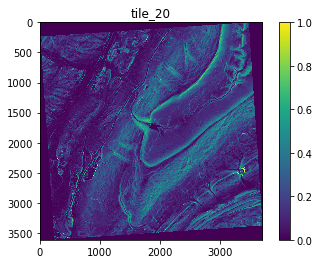

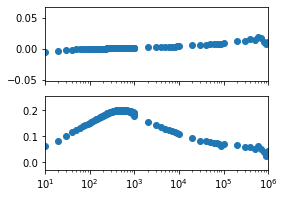

In [3]:
darea = rasterio.open(filename + '_dinf_area.tif')
curve = rasterio.open(filename + '_CURV.tif')
slope = rasterio.open(filename + '_SLOPE.tif')
elev = rasterio.open(filename + '_ELEV.tif')
#Simple nodata mask. different from the mask we'll make later
msk_d = darea.read_masks()

#In order to turn raater data into statistics you need to flatten the rows of data out
#I'm pretty sure this is where other people use GeoPandas. Whoops.
darea_data = darea.read(1, masked=True)
curve_data = curve.read(1, masked=True)
slope_data = slope.read(1, masked=True)
darea_array=darea_data.flatten()
curve_array=curve_data.flatten()
slope_array=slope_data.flatten()

plt.imshow(slope.read(1), vmin=0, vmax=1)
plt.colorbar()
plt.title(filename)


## And now this part, where I bin the data logarithmically (but by tens of m2 until 1000 m^2)

#Bin edges go by 10 until 1000 m^2
a1=10.**(np.arange(3, 7)) 
a2 = np.arange(1,10,1)
a3 = np.arange(0,1000,10)
bin_edges = np.append(a3, (np.outer(a1, a2).flatten()))

med_stat_ca = binned_statistic(darea_array,curve_array,
                            statistic='median',
                            bins=bin_edges)

med_stat_sa = binned_statistic(darea_array,slope_array,
                            statistic='median',
                            bins=bin_edges)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4,3), sharex=True)
ax1.scatter(med_stat_ca.bin_edges[:-1],med_stat_ca.statistic)
ax2.scatter(med_stat_sa.bin_edges[:-1],med_stat_sa.statistic)
ax1.set_xscale('log')
ax1.set_xlim(1e1, 1e6)

In [4]:
#THIS is the fuckery I got into because LSDTT is smart enough to turn things from 18N to 17N if they're actually far enough east
#Like I mosaicked PA and WV together as an 18N raster but LSDTT would take WV tiles and make them 17N
#So I have two Tuscarora shapefiles and depending on the LSDTT projection you pick one

gdem = gdal.Open(filename + '_UTM.tif', gdal.GA_ReadOnly)
proj=gdem.GetProjection()
#So it looks like LSDTT might get the projection but I don't know how to tap that so I literally just
#grab from this massive unformatted string the UTM zone from the gdal command
proj=(proj[20:32])

if '17N' in proj:
    with fiona.open("Tuscarora_17N.shp", "r") as shapefile:
        Tuscarora_mask = [feature["geometry"] for feature in shapefile]
    print('17N')
elif '18N' in proj:
    with fiona.open("Tuscarora_18N.shp", "r") as shapefile:
        Tuscarora_mask = [feature["geometry"] for feature in shapefile]
    print('18N')
else:
    print('u r fucked') #I was very frustrated

17N


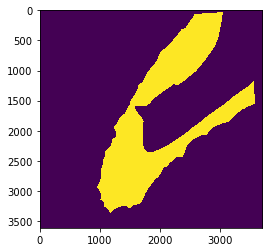

In [7]:
#This is the masking step
out_image, out_transform = rasterio.mask.mask(slope, Tuscarora_mask, crop=True)
out_meta = slope.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})

from rasterio.plot import show
show(out_image)

In [8]:


slope_tusc, out_transform = rasterio.mask.mask(slope, Tuscarora_mask, crop=True)
out_meta = slope.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})

curve_tusc, out_transform = rasterio.mask.mask(curve, Tuscarora_mask, crop=True)
out_meta = slope.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})
darea_tusc, out_transform = rasterio.mask.mask(darea, Tuscarora_mask, crop=True)
out_meta = slope.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})

darea_t_array=darea_tusc.flatten()
curve_t_array=curve_tusc.flatten()
slope_t_array=slope_tusc.flatten()

med_stat_t_ca = binned_statistic(darea_t_array,curve_t_array,
                            statistic='median',
                            bins=bin_edges)

med_stat_t_sa = binned_statistic(darea_t_array,slope_t_array,
                            statistic='median',
                            bins=bin_edges)


In [11]:
slope_ntusc, out_transform = rasterio.mask.mask(slope, Tuscarora_mask, invert=True)
out_meta = slope.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})

curve_ntusc, out_transform = rasterio.mask.mask(curve, Tuscarora_mask, invert=True)
out_meta = curve.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})
darea_ntusc, out_transform = rasterio.mask.mask(darea, Tuscarora_mask, invert=True)
out_meta = darea.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})
# with rasterio.open("Tusc_masked.tif", "w", **out_meta) as dest:
#     dest.write(out_image)
darea_nt_array=darea_ntusc.flatten()
curve_nt_array=curve_ntusc.flatten()
slope_nt_array=slope_ntusc.flatten()
med_stat_nt_ca = binned_statistic(darea_nt_array,curve_nt_array,
                            statistic='median',
                            bins=bin_edges)

med_stat_nt_sa = binned_statistic(darea_nt_array,slope_nt_array,
                            statistic='median',
                            bins=bin_edges)

# 3. Save it to a csv with pandas

In [12]:
df = pd.DataFrame(list(zip(bin_edges[1:],med_stat_sa.statistic.tolist(),med_stat_ca.statistic.tolist(),
                        med_stat_t_sa.statistic.tolist(),med_stat_t_ca.statistic.tolist(),
                        med_stat_nt_sa.statistic.tolist(),med_stat_nt_ca.statistic.tolist())),
               columns = ['Bin', 'Slp_all', 'Curv_all', 'Slp_tusc', 'Curv_tusc', 'Slp_ntsc', 'Curv_ntusc'])

ds = gdal.Open(RasterFile)
df['topleftx'] = np.array(ds.GetGeoTransform()[0], dtype=np.float32)
df['toplefty']  = np.array(ds.GetGeoTransform()[3], dtype=np.float32)
df['ref']  = ds.GetProjection()[0:45]


df.to_csv(filename + '_stats_tests.csv',columns=df.columns, index=False)